In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPool2D, BatchNormalization, AlphaDropout
from keras.optimizers import Adam
from skopt.acquisition import gaussian_ei
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [3]:
def build_model(lr):
    model = Sequential()
    
    for i in range(3):
        if i == 0:
            model.add(Conv2D(32, 3, kernel_initializer='he_uniform', padding='same', input_shape=(28,28,1)))
        else:
            model.add(Conv2D(32, 3, kernel_initializer='he_uniform', padding='same'))
        
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D())
            
    model.add(Flatten())
    model.add(Dense(2**10, kernel_initializer='lecun_normal', activation='selu'))
    model.add(AlphaDropout(0.31149362686636906))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(lr=lr),
                  metrics=['accuracy'])
    
    return model

def eval_model(model):
    model.fit(x_train, y_train, epochs=5, batch_size=1024, verbose=0)
    l = model.evaluate(x_test, y_test, batch_size=1024, verbose=0)[0]
    
    return l

def objective(params):
    model = build_model(params)
    return eval_model(model)


def plot_optimizer(opt, x, next_x=None, plot_points=5, fs=(12, 5), auto_xscale=True, xlims=None):
    plt.figure(figsize=fs)
    model = opt.models[-1] if len(opt.models) > 0 else None
    ymax = 0
    
    # X limits
    idxs = np.argsort(opt.yi)[:plot_points]
    if (len(opt.yi) > plot_points) and auto_xscale:
        xs = np.array(opt.Xi).ravel()[idxs]
        xmin = min(opt.Xi[-1], np.min(xs))
        xmax = max(opt.Xi[-1], np.max(xs))
        
        if next_x is not None:
            xmin = min(xmin, next_x[0])
            xmax = max(xmax, next_x[0])
        
        ymax = opt.yi[idxs[-1]]
        margin = (xmax - xmin) * 0.01
        plt.xlim(xmin-margin, xmax+margin)
        plt.ylim(0, ymax)
        x = np.linspace(xmin, xmax, 100).reshape(-1, 1)
    else:
        if xlims is None:
            xmin, xmax = np.min(x), np.max(x)
        else:
            xmin, xmax = xlims
            x = np.linspace(max(xmin, np.min(x)), min(xmax, np.max(x)), 100).reshape(-1, 1)
            
        margin = (xmax - xmin) * 0.01
        plt.xlim(xmin-margin, xmax+margin)
    
    # Plot Model(x) + contours
    if model is not None:
        x_model = opt.space.transform(x.tolist())
        y_pred, sigma = model.predict(x_model, return_std=True)
        plt.plot(x, y_pred, 'g--', label=r'$\mu(x)$')
        plt.fill(np.concatenate([x, x[::-1]]),
                 np.concatenate([y_pred - 1.9600 * sigma, 
                                 (y_pred + 1.9600 * sigma)[::-1]]),
                 alpha=.2, fc='g', ec='None')
        
        acq = gaussian_ei(x_model, model, y_opt=np.min(opt.yi))
        # Adjust to make a better plot
        ymin = np.min(y_pred - 1.9600 * sigma)
        ymax = np.max(y_pred + 1.9600 * sigma)
        space = (ymax - ymin) / 4 # scaling the acq function to 20% of the plot
        a = ymin - space
        b = a + 0.95*space
        scale = (b - a) / np.max(acq)
        acq *= scale
        acq += a
        plt.ylim(a, ymax)
        plt.plot(x, acq, 'b', label='EI(x)')
        plt.fill_between(x.ravel(), np.min(acq), acq.ravel(), alpha=0.3, color='blue')

    # Get best points
    best_y, best_x = opt.yi[idxs[0]], opt.Xi[idxs[0]][0]
    
    if next_x is not None:
        # Plot next point
        next_x_y = 0
        if model is not None:
            next_x_y = model.predict(opt.space.transform([next_x]))

        plt.plot(next_x, next_x_y, '*', color='#000000', markersize=25)
        plt.plot(next_x, next_x_y, '*', color='#feec02', markersize=20, label='Next sample')
    else:
        # Plot best point
        plt.plot(best_x, best_y, '*g', markersize=25, label='Best lr')
        
    # Plot sampled points
    plt.plot(opt.Xi, opt.yi, 'r.', markersize=8, label='Observations')
    plt.plot(opt.Xi[-1], opt.yi[-1], 'r.', markersize=20)
    
    # Adjust plot layout
    plt.grid()
    plt.legend(loc='best')
    print('Best lr           : %.6f (loss=%.6f)' % (best_x, best_y))
    plt.show()

def run_optimize(opt, x, plot_fn, n_iters):
    init_iter = len(opt.Xi)
    for i in range(init_iter, init_iter+n_iters):
        print(f'Iteration {i+1}')
        if i == init_iter: next_x = opt.ask()
        if i < opt.n_initial_points_:
            print('Sampling random lr: %.6f' % (next_x[0]), end='')
        else:
            print('Sampling best lr  : %.6f' % (next_x[0]), end='')

        f_val = objective(next_x)
        print(' (loss=%.6f)' % f_val)
        opt.tell(next_x, f_val)
        next_x = opt.ask()
        if i != init_iter+n_iters-1:
            plot_fn(opt, x, next_x)
        else:
            plot_fn(opt, x)
    
    idx = np.argmin(opt.yi)
    best_lr = opt.Xi[idx][0]
    print('\nDone:')
    print('Best learning rate = %.6f' % best_lr) 
    
    return best_lr
    
    
# plot = partial(plot_optimizer, plot_points=plot_points)
# plot(opt, x)

Iteration 1
Sampling random lr: 0.005285 (loss=0.095664)
Best lr           : 0.005285 (loss=0.095664)


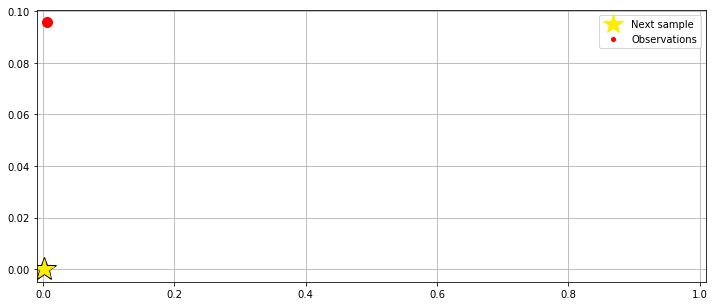

Iteration 2
Sampling random lr: 0.000725 (loss=0.087523)
Best lr           : 0.000725 (loss=0.087523)


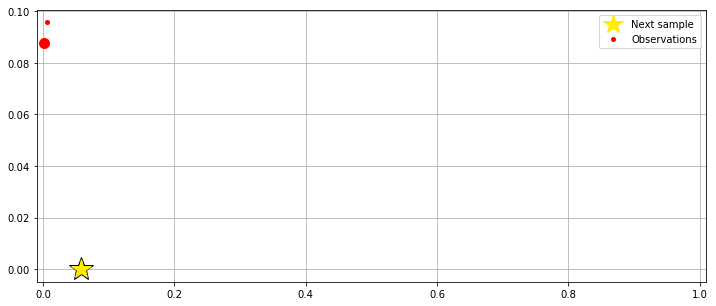

Iteration 3
Sampling random lr: 0.057500 (loss=14.288693)
Best lr           : 0.000725 (loss=0.087523)


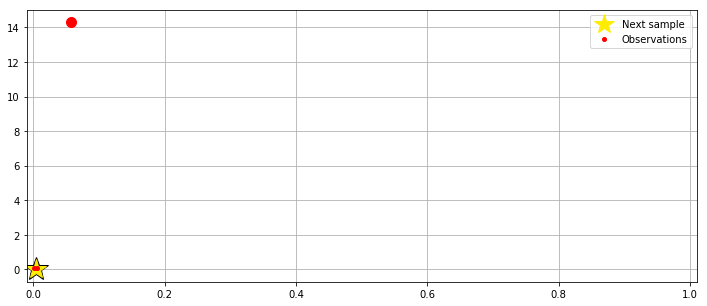

Iteration 4
Sampling random lr: 0.004104 (loss=0.047702)
Best lr           : 0.004104 (loss=0.047702)


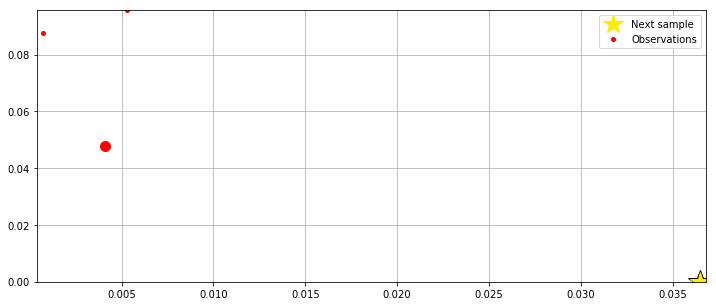

Iteration 5
Sampling random lr: 0.036474 (loss=14.461155)
Best lr           : 0.004104 (loss=0.047702)


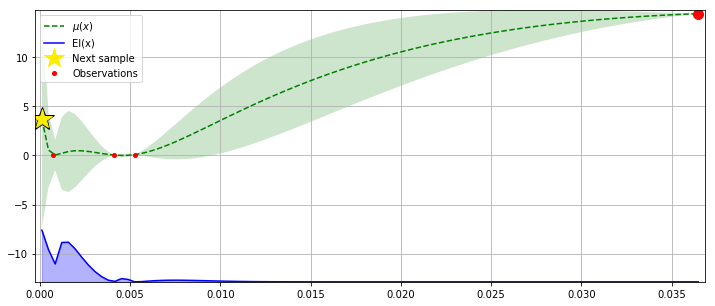

Iteration 6
Sampling best lr  : 0.000124 (loss=0.115708)
Best lr           : 0.004104 (loss=0.047702)


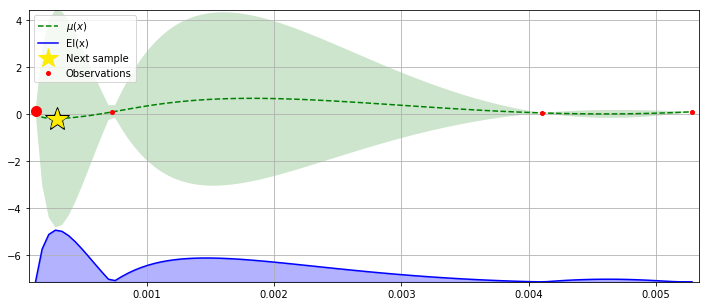

Iteration 7
Sampling best lr  : 0.000290 (loss=0.064658)
Best lr           : 0.004104 (loss=0.047702)


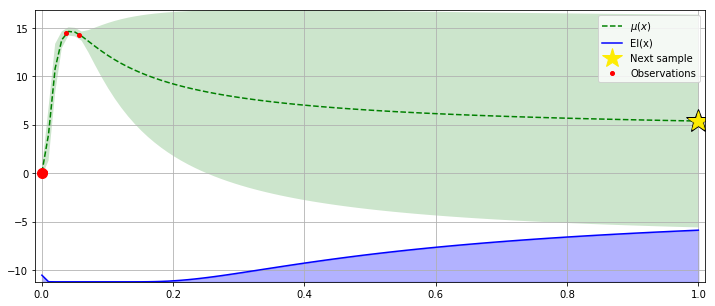

Iteration 8
Sampling best lr  : 0.999977 (loss=14.490168)
Best lr           : 0.004104 (loss=0.047702)


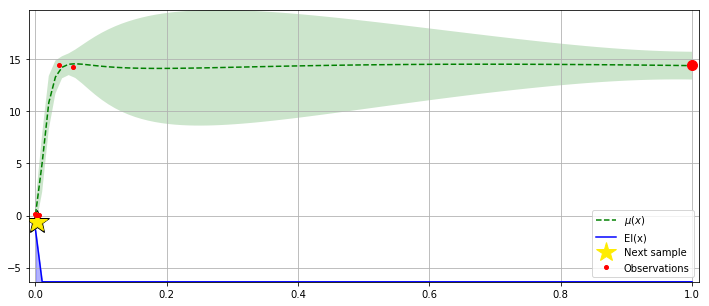

Iteration 9
Sampling best lr  : 0.003281 (loss=0.041081)
Best lr           : 0.003281 (loss=0.041081)


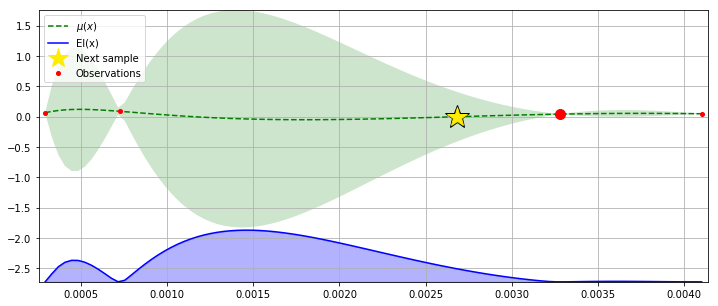

Iteration 10
Sampling best lr  : 0.002684 (loss=0.063757)
Best lr           : 0.003281 (loss=0.041081)


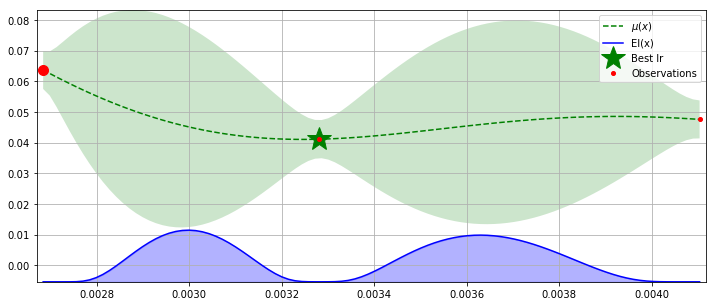


Done:
Best learning rate = 0.003281


In [4]:
from skopt import Optimizer

n_samplings = 10
random_samples = 5
plot_points = 3
plot_fn = partial(plot_optimizer, plot_points=plot_points)
opt = Optimizer([(1e-4, 1e-0, 'log-uniform')], acq_optimizer='sampling', n_initial_points=random_samples)

# Start optimization
x = np.linspace(1e-4, 1e-0, 400).reshape(-1, 1)
run_optimize(opt, x, plot_fn, n_samplings);

Iteration 11
Sampling best lr  : 0.000188 (loss=0.072935)
Best lr           : 0.003281 (loss=0.041081)


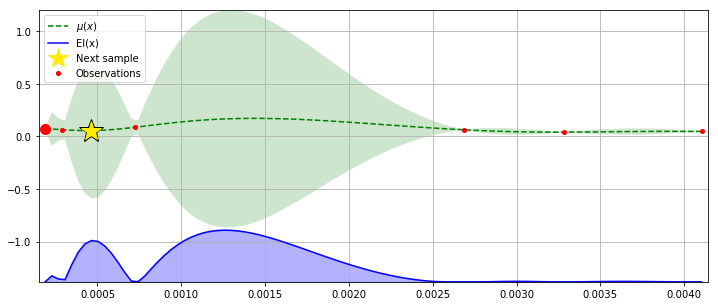

Iteration 12
Sampling best lr  : 0.000462 (loss=0.073561)
Best lr           : 0.003281 (loss=0.041081)


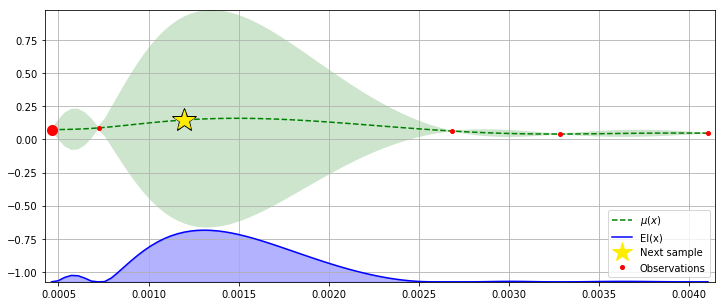

Iteration 13
Sampling best lr  : 0.001194 (loss=0.059427)
Best lr           : 0.003281 (loss=0.041081)


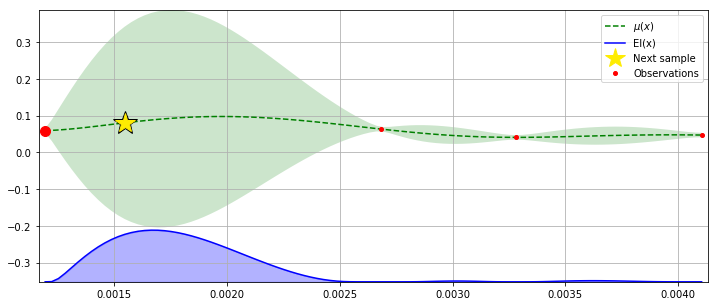

Iteration 14
Sampling best lr  : 0.001548 (loss=0.088853)
Best lr           : 0.003281 (loss=0.041081)


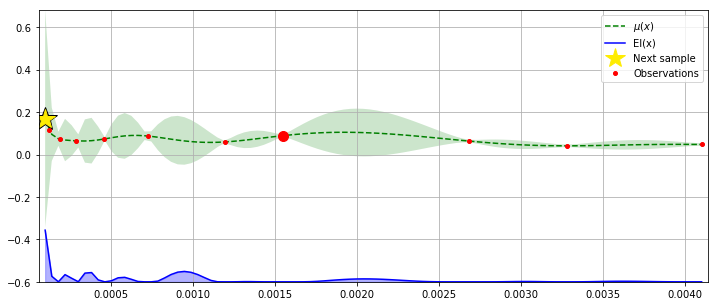

Iteration 15
Sampling best lr  : 0.000100 (loss=0.119094)
Best lr           : 0.003281 (loss=0.041081)


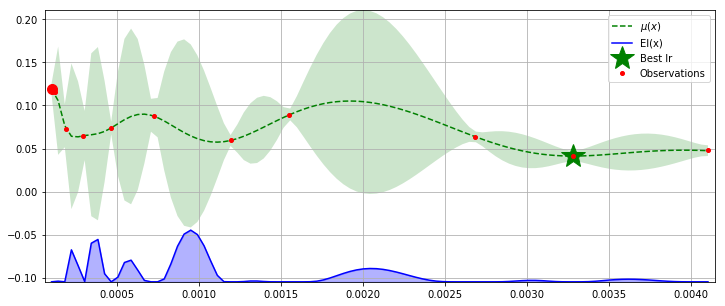


Done:
Best learning rate = 0.003281


In [5]:
extra_sampling = 5
run_optimize(opt, x, plot_fn, extra_sampling);

Best lr           : 0.003281 (loss=0.041081)


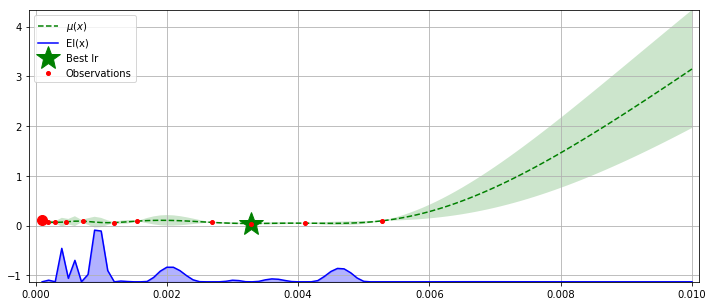

In [15]:
# Complete plot
plot_fn(opt, x, auto_xscale=False, xlims=(0, 0.01))

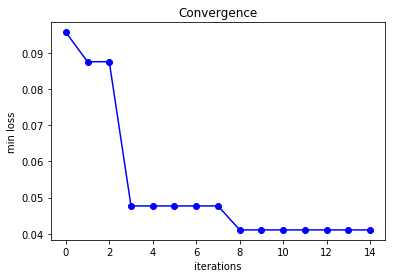

In [16]:
mins = [np.min(opt.yi[:n+1]) for n,i in enumerate(opt.yi)]
plt.plot(mins, 'o-b')
plt.title('Convergence')
plt.ylabel('min loss')
plt.xlabel('iterations')
plt.show()